In [1]:
import pandas as pd
import numpy as np
import os
from igraph import Graph, plot
import matplotlib.pyplot as plt
import utils
from collections import Counter, defaultdict
import networkx as nx


%load_ext autoreload
%aimport utils
%autoreload 1

# Read data and preprocess

In [2]:
TAX_LEVEL = 5
OUTDIR = 'data/16S_family_ur'
SEASON = 'Upwelling Relaxation'

os.makedirs(OUTDIR, exist_ok=True)

In [3]:
df_raw = pd.read_excel('data/16S_AV_OTU_table_wTaxa.xlsx')
meta = pd.read_excel('data/16S_AV_March2019_Metadata.xlsx')

df_raw = df_raw.set_index(['OTU', 'taxonomy'])
df_raw = utils.subset_by_season(df_raw, meta, SEASON) # Only get samples in the season

In [4]:
df_filtered = utils.filter_by_abundance(df_raw, .001)
df_filtered = utils.filter_by_prevalence(df_filtered, 3)
df_filtered = df_filtered.reset_index().drop(columns='taxonomy').set_index('OTU')
df_filtered_relative = df_filtered / df_raw.sum()
len(df_filtered) / len(df_raw)

0.011598065343993682

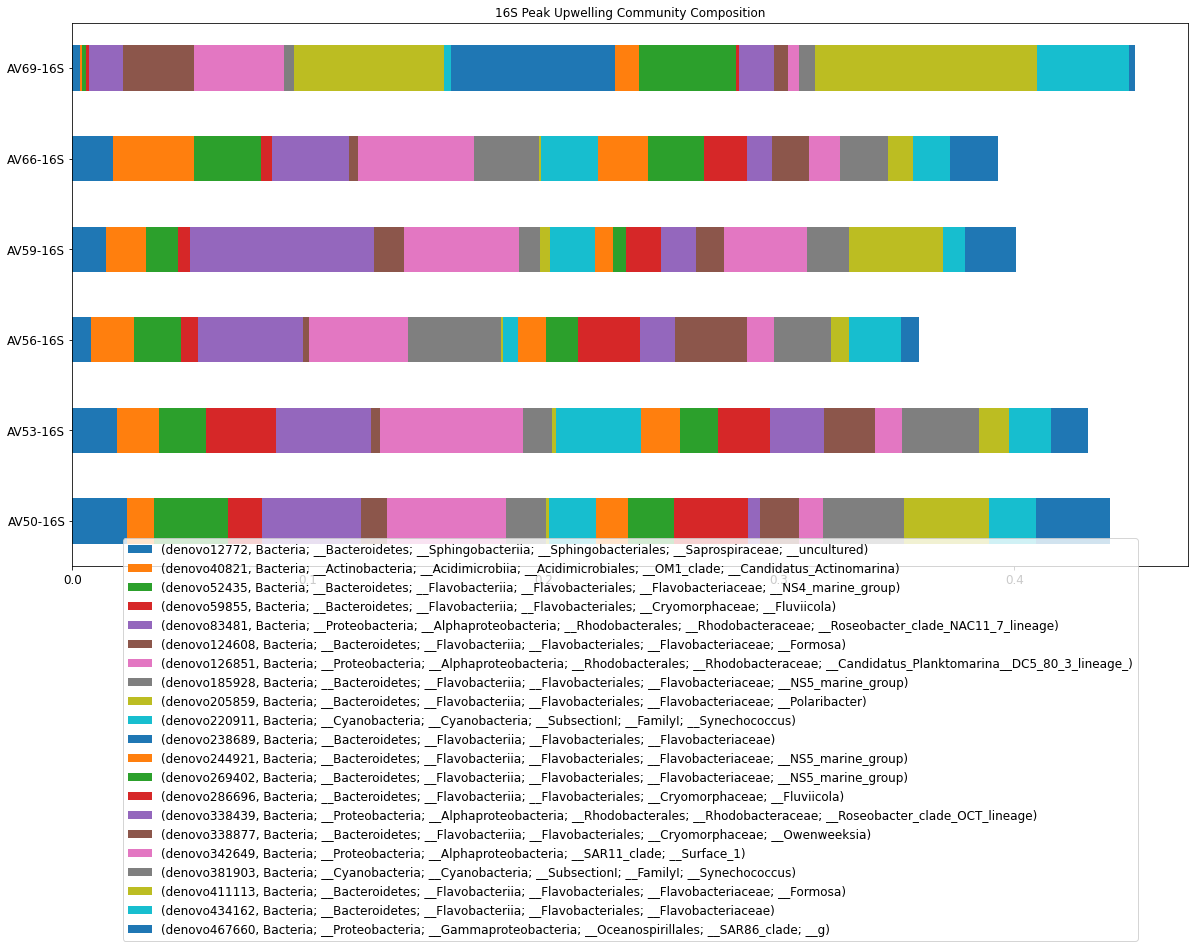

In [5]:
most_abundance = utils.filter_by_abundance(df_raw, .02)
most_abundance = utils.filter_by_prevalence(most_abundance, 3)
most_abundance_relative = most_abundance / df_raw.sum()

f = plt.figure()
time = meta.set_index('Sample_Names').loc[most_abundance.columns]['Month'] + '-2018'
plt.title('16S Peak Upwelling Community Composition', color='black', fontsize=12)
most_abundance_relative.T.plot(kind='barh', stacked=True, figsize=(20, 10), ax=f.gca(), fontsize=12)
plt.legend(loc='lower center', bbox_to_anchor=(.5, -.7), fontsize=12)
plt.savefig('16s_pu_composition.jpg', bbox_inches='tight')

# Build graph

In [6]:
from datetime import datetime
start = datetime.now()
df_cor, df_pval = utils.run_sparcc(df_filtered, OUTDIR, force=True)
(datetime.now() - start).seconds

156

In [7]:
threshold = utils.correct_pvals(df_pval)
print(threshold)
min_pval = df_pval.min().min()
print(min_pval)

0
0.001


In [8]:
df_cor[df_pval > max(threshold, min_pval)] = 0

(array([1.0000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.7471e+04,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.4000e+01]),
 array([-0.9708 , -0.77392, -0.57704, -0.38016, -0.18328,  0.0136 ,
         0.21048,  0.40736,  0.60424,  0.80112,  0.998  ]),
 <a list of 10 Patch objects>)

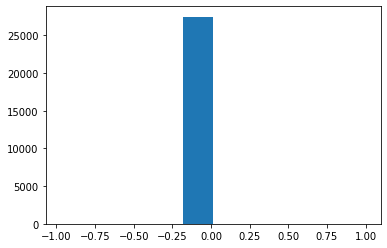

In [9]:
flatten_cor = utils.flatten_square_df(df_cor, k=1)
plt.hist(flatten_cor)

In [10]:
flatten_cor[flatten_cor != 0].describe()

count    24.000000
mean      0.171583
std       0.964897
min      -0.970800
25%      -0.936150
50%       0.953750
75%       0.970525
max       0.998000
dtype: float64

In [11]:
G = nx.from_pandas_adjacency(df_cor)

In [12]:
OTU_to_tax = {OTU:tuple(x.strip('_') for x in tax.split('; ')) for OTU, tax in df_raw.index if OTU in G}

In [13]:
for OTU, tax in OTU_to_tax.items():
    G = nx.relabel_nodes(G, {OTU:tax+(OTU,)})

In [14]:
for node, attrs in G.nodes.items():
    attrs['OTUs'] = 1

In [15]:
utils.merge_nodes_to_level(G, 6, 5)

Original #nodes: 235
Level 6 #nodes: 90
Level 5 #nodes: 59


In [16]:
utils.add_node_attrs(G, TAX_LEVEL, df_filtered_relative, OTU_to_tax)
utils.add_edge_attrs(G)

In [17]:
top_connected = [x for x, y in sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]]
top_abundance = sorted(G.nodes, key=lambda n: G.nodes[n]['abundance'], reverse=True)[:5]

for n, attrs in G.nodes.items():
    if n in top_connected and n in top_abundance:
        attrs['color'] = 'orange'
    elif n in top_connected:
        attrs['color'] = 'red'
    elif n in top_abundance:
        attrs['color'] = 'yellow'

In [18]:
t = nx.transitivity(G)
print(f"Transitivity: {t}")

count_t = 0
for _ in range(10000):
    random_G = nx.gnm_random_graph(len(G.nodes), len(G.edges))
    if nx.transitivity(random_G) >= t:
        count_t += 1
print(f'p-value: {count_t/10000}')

Transitivity: 0
p-value: 1.0


# Env vars

In [19]:
env_vars = meta.set_index('Sample_Names').loc[df_filtered_relative.columns][['Temp_C', 'Salinity', 'Chlorophyll_ugL']]

In [20]:
for env_var in env_vars:
    env_cor = utils.calc_spearman_cor(df_filtered_relative, env_vars[env_var])
    utils.add_env_node(G, env_cor, OTU_to_tax)

/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nguyenlienviet/.local/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
nx.write_gml(G, os.path.join(OUTDIR, 'graph.gml'), stringizer=lambda x: '; '.join(x) if type(x)!=str else x)